In [2]:
# Install Kaggle
!pip install kaggle

# Create a Kaggle directory and upload kaggle.json
import os
from google.colab import files

# Create a Kaggle directory
os.makedirs("/root/.kaggle", exist_ok=True)

# Upload kaggle.json
print("Please upload your kaggle.json file")
uploaded = files.upload()

# Move kaggle.json to the directory
for filename in uploaded.keys():
    os.rename(filename, "/root/.kaggle/kaggle.json")

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json

# Download a Kaggle dataset (replace 'dataset-owner/dataset-name' with your dataset)
!kaggle competitions download -c data-science-bowl-2018


Please upload your kaggle.json file


Saving kaggle (1).json to kaggle (1).json
100% 358M/358M [00:01<00:00, 263MB/s]
100% 358M/358M [00:01<00:00, 247MB/s]


In [3]:

# Unzip the dataset
import zipfile

# Replace 'dataset-name.zip' with the downloaded file name
with zipfile.ZipFile("/content/data-science-bowl-2018.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

print("Dataset downloaded and unzipped successfully!")


Dataset downloaded and unzipped successfully!


In [4]:
# Specify the folder where you want to extract the files
extract_folder = "train"
extract_folder2= "test"

# Create the folder if it doesn't exist
os.makedirs(extract_folder, exist_ok=True)
with zipfile.ZipFile("/content/stage1_train.zip", 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

os.makedirs(extract_folder2, exist_ok=True)
with zipfile.ZipFile("/content/stage1_test.zip", 'r') as zip_ref:
    zip_ref.extractall(extract_folder2)

In [5]:
import os
len(os.listdir("/content/train"))

670

In [6]:
import tensorflow as tf
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize

np.random.seed(42)

In [7]:
img_width=128
img_height=128
img_size=(img_width,img_height)
img_channels=3

train_path="/content/train"
test_path="/content/test"

train_id=next(os.walk(train_path))[1]
test_id=next(os.walk(test_path))[1]




In [8]:
x_train=np.zeros((len(train_id),img_height,img_width,img_channels),dtype=np.uint8)
y_train=np.zeros((len(train_id),img_height,img_width,1),dtype=bool)

In [9]:
for n,id in tqdm(enumerate(train_id), total=len(train_id)):
  path=train_path + "/" + id
  img=imread(path+"/images/"+id+".png")[:,:,:img_channels]
  img=resize(img,img_size,mode="constant",preserve_range=True)
  x_train[n]=img
  mask=np.zeros((img_height,img_width,1),dtype=bool)
  for _mask in next(os.walk(path+"/masks/"))[2]:
    _mask=imread(path+"/masks/"+_mask)
    _mask=np.expand_dims(resize(_mask,img_size,mode="constant",preserve_range=True),axis=-1)
    mask=np.maximum(mask,_mask)
  y_train[n]=mask

100%|██████████| 670/670 [04:18<00:00,  2.59it/s]


array([[[ 7,  7,  7],
        [15, 15, 15],
        [22, 22, 22],
        ...,
        [16, 16, 16],
        [10, 10, 10],
        [ 6,  6,  6]],

       [[ 9,  9,  9],
        [21, 21, 21],
        [32, 32, 32],
        ...,
        [ 9,  9,  9],
        [ 6,  6,  6],
        [ 5,  5,  5]],

       [[ 9,  9,  9],
        [22, 22, 22],
        [38, 38, 38],
        ...,
        [ 5,  5,  5],
        [ 4,  4,  4],
        [ 3,  3,  3]],

       ...,

       [[ 2,  2,  2],
        [ 2,  2,  2],
        [ 2,  2,  2],
        ...,
        [ 2,  2,  2],
        [ 2,  2,  2],
        [ 1,  1,  1]],

       [[ 2,  2,  2],
        [ 2,  2,  2],
        [ 2,  2,  2],
        ...,
        [ 2,  2,  2],
        [ 2,  2,  2],
        [ 2,  2,  2]],

       [[ 2,  2,  2],
        [ 2,  2,  2],
        [ 2,  2,  2],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]]], dtype=uint8)
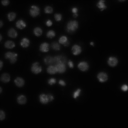

In [10]:
x_train[0]

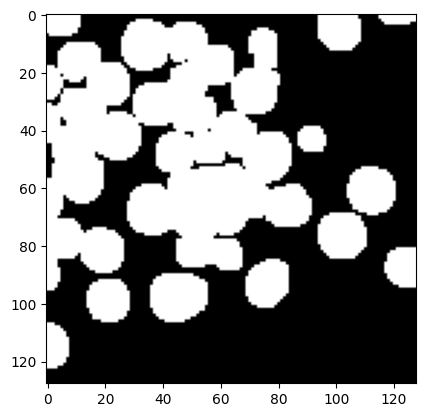

In [11]:
plt.imshow(y_train[0],cmap="gray")

In [12]:
import tensorflow as tf

# Input shape
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# U-Net Model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)  # Normalize inputs to [0, 1]

# Contracting Path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive Path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

# Build the model
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128, 128, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            448 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 32)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 128)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)       

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
checkpoint_filepath = 'checkpoint.model.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

earlystopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0,
    restore_best_weights=True
)
log_dir="logs"

tb_callback = tf.keras.callbacks.TensorBoard( log_dir=log_dir)


In [14]:
callbacks=[model_checkpoint_callback,earlystopping,tb_callback]

In [15]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [16]:
history = model.fit(x_train,y_train,epochs=50,validation_split=0.2,batch_size=16,callbacks=callbacks)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 470ms/step - accuracy: 0.7149 - loss: 0.7942 - val_accuracy: 0.7873 - val_loss: 0.5211
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.7869 - loss: 0.4636 - val_accuracy: 0.8345 - val_loss: 0.3246
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8716 - loss: 0.2923 - val_accuracy: 0.9201 - val_loss: 0.2137
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9309 - loss: 0.1864 - val_accuracy: 0.9337 - val_loss: 0.1759
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9441 - loss: 0.1448 - val_accuracy: 0.9474 - val_loss: 0.1319
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9476 - loss: 0.1374 - val_accuracy: 0.9484 - val_loss: 0.1361
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9436 - loss: 0.1473 - val_accuracy: 0.9552 - val_loss: 0.1107
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9514 - loss: 0.1333 - val_accuracy: 0.9602 

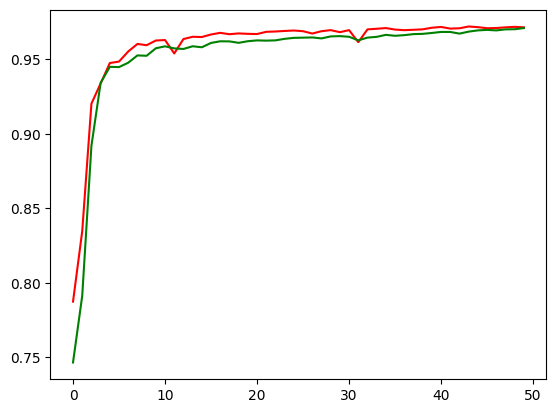

In [17]:
plt.plot(history.history['val_accuracy'],color='red')
plt.plot(history.history['accuracy'],color='green')


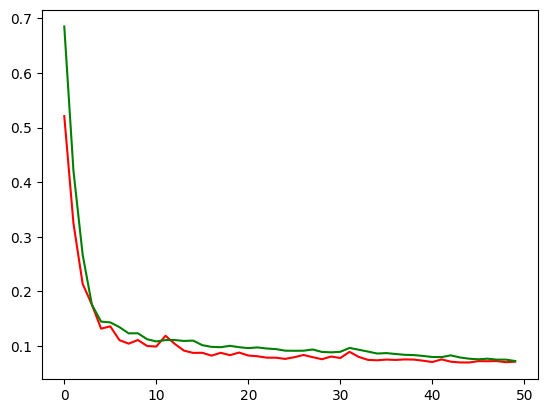

In [18]:

plt.plot(history.history['val_loss'],color='red')
plt.plot(history.history['loss'],color='green')


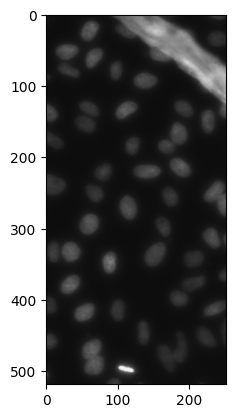

In [19]:
img=imread("/content/test/0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac/images/0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac.png")
plt.imshow(img)

In [49]:
pred_train = model.predict(x_train[:int(x_train.shape[0]*0.9)], verbose =1)
pred_test = model.predict(x_train[int(x_train.shape[0]*0.9):], verbose =1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [50]:
pred_train_t = (pred_train > 0.5).astype(np.uint8)
pred_test_t = (pred_test > 0.5).astype(np.uint8)

array([[[156, 141, 181],
        [169, 152, 196],
        [169, 155, 198],
        ...,
        [167, 155, 197],
        [167, 151, 197],
        [158, 141, 183]],

       [[166, 150, 193],
        [182, 163, 209],
        [180, 164, 211],
        ...,
        [175, 160, 207],
        [177, 159, 207],
        [167, 151, 193]],

       [[169, 152, 194],
        [182, 164, 209],
        [180, 160, 209],
        ...,
        [175, 159, 206],
        [178, 160, 207],
        [168, 151, 194]],

       ...,

       [[166, 147, 193],
        [178, 160, 207],
        [177, 159, 206],
        ...,
        [178, 161, 209],
        [179, 160, 209],
        [165, 147, 194]],

       [[167, 150, 195],
        [179, 160, 208],
        [176, 158, 207],
        ...,
        [178, 160, 210],
        [178, 159, 210],
        [160, 142, 195]],

       [[158, 142, 184],
        [170, 154, 197],
        [171, 152, 197],
        ...,
        [169, 153, 199],
        [168, 150, 199],
        [149, 131, 184]]], dtype=uint8)
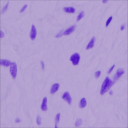

In [36]:
x_train[3]

<ipython-input-41-58af727c3612>:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(y_train[3])


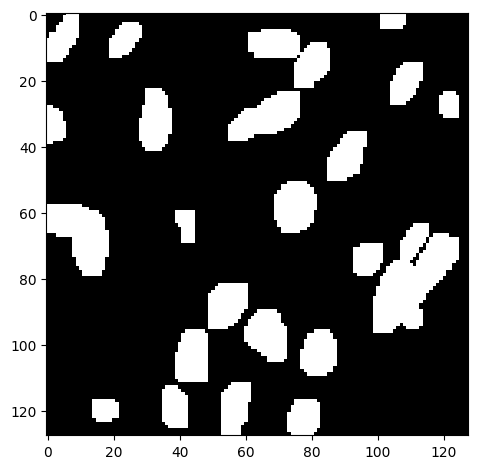

In [41]:
imshow(y_train[3])


In [46]:
x_train.dtype

dtype('uint8')

In [53]:
path = "/content/WhatsApp Image 2025-01-16 at 03.25.05_72e9caa3.jpg"

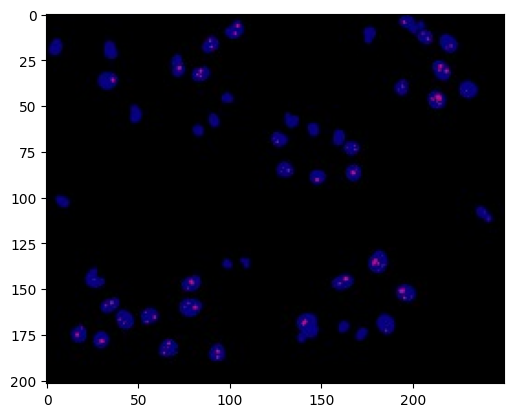

In [54]:
img = imread(path)
plt.imshow(img)

In [55]:
img.shape

(202, 250, 3)

In [56]:
img = resize(img, (128, 128, 3), mode = 'constant', preserve_range = True)

In [58]:
img = img.reshape(1,128,128,3)

In [59]:
pred = model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [60]:
pred = (pred>0.5).astype(np.uint8)

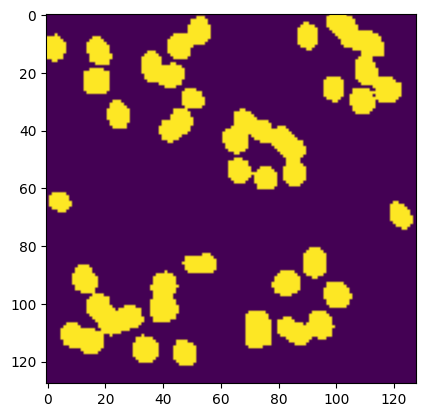

In [62]:
plt.imshow(pred[0])